[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanharvey1/neuro_py/blob/main/tutorials/bias_correlation.ipynb)
&nbsp;
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ryanharvey1/neuro_py/main/tutorials/bias_correlation.ipynb)
&nbsp;
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanharvey1/neuro_py/main?labpath=tutorials%2Fbias_correlation.ipynb)

# Pairwise Bias Correlation Analysis 

In this tutorial, we'll explore how to use the [`PairwiseBias`](https://ryanharvey1.github.io/neuro_py/reference/neuro_py/ensemble/replay/#neuro_py.ensemble.replay.PairwiseBias) class to analyze neural replay events. We'll simulate spike data for both task and post-task periods, and then use the PairwiseBias transformer to detect significant replay events.

---

## Setup

First, let's import the necessary libraries and set up our environment.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
import copy
import logging

import ipywidgets as widgets
import matplotlib.pyplot as plt
import nelpy as nel
import numpy as np
import scipy

import neuro_py as npy

# Disable logging
logger = logging.getLogger()
logger.disabled = True

# Set random seed for reproducibility
np.random.seed(0)

## Section 1: Simulate Data

### Section 1.1: Simulating Task Spike Data with Replay Events

We'll start by simulating spike data for a task period. This will represent the
original neural activity that we want to detect in replay events.

In [2]:
def simulate_sequential_spikes(
    nneurons=30,
    minseqduration=0.05,
    maxseqduration=0.15,
    duration=1.0,
    jitter=0.01,
    reverseseqprob=0.0,
    random=False,
):
    spikes = []
    neuron_ids = []
    max_nsequences = np.ceil(duration / minseqduration)
    sequence_durations = np.random.uniform(
        minseqduration, maxseqduration, int(max_nsequences)
    )
    # get index of last sequence that fits into duration
    last_sequence = np.where(np.cumsum(sequence_durations) <= duration)[0][-1]
    sequence_durations = sequence_durations[: last_sequence + 1]
    sequence_epochs = np.cumsum(sequence_durations)
    sequence_epochs = np.asarray(
        (np.r_[0, sequence_epochs][:-1], sequence_epochs)
    ).T  # shape (nsequences, 2)

    for seq_start, seq_end in sequence_epochs:
        spike_ts = np.linspace(seq_start, seq_end, nneurons)
        neuron_seqids = (
            np.arange(nneurons)
            if np.random.rand() > reverseseqprob
            else np.arange(nneurons)[::-1]
        )
        # add jitter
        spike_ts += np.random.uniform(-jitter, jitter, nneurons)
        spike_ts = np.sort(spike_ts)
        # clip to sequence bounds
        spike_ts = np.clip(spike_ts, seq_start, seq_end)
        spikes.append(spike_ts)
        neuron_ids.append(neuron_seqids)

    spikes = np.concatenate(spikes)
    neuron_ids = np.concatenate(neuron_ids)

    if random:
        neuron_ids = np.random.permutation(neuron_ids)

    return spikes, neuron_ids, sequence_epochs

Set parameters for simulation of spike data.

In [3]:
N_NEURONS = 15
MIN_SEQ_DURATION = 0.05
MAX_SEQ_DURATION = 0.15
DURATION = 0.5

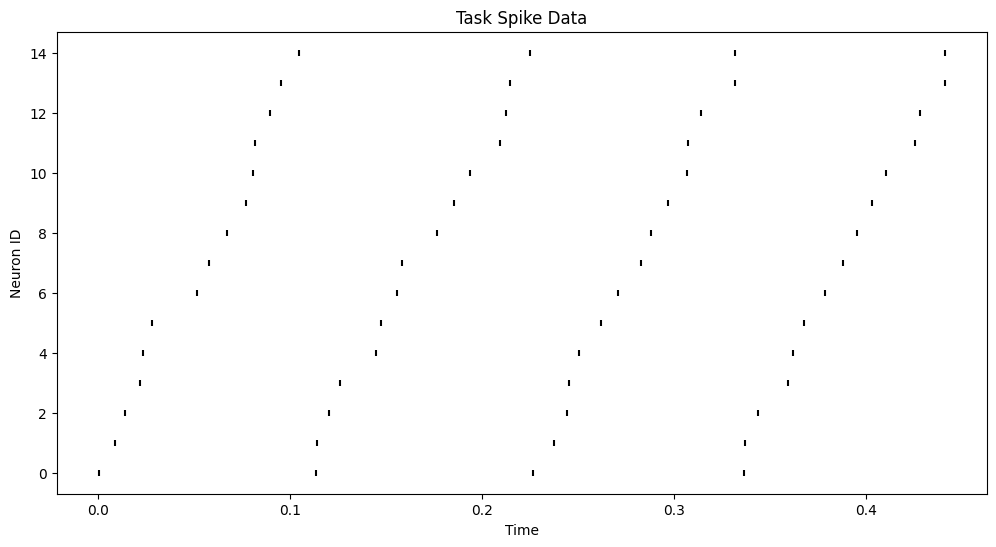

In [4]:
task_spikes, task_neurons, task_seq_epochs = simulate_sequential_spikes(
    nneurons=N_NEURONS,
    minseqduration=MIN_SEQ_DURATION,
    maxseqduration=MAX_SEQ_DURATION,
    duration=DURATION,
    random=False,
)

# Visualize task spike data
plt.figure(figsize=(12, 6))
plt.scatter(task_spikes, task_neurons, c="k", marker="|", s=18)
plt.title("Task Spike Data")
plt.xlabel("Time")
plt.ylabel("Neuron ID")
plt.show()

### Section 1.2: Simulating Post-Task Spike Data with Forward Replay

Now, let's simulate post-task spike data for both significant and
non-significant replay scenarios, and visualize them.

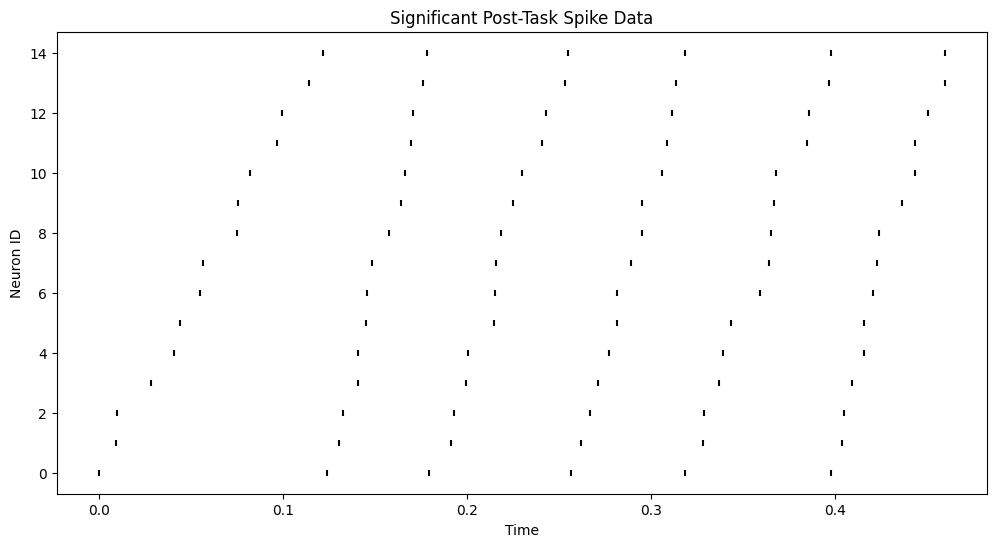

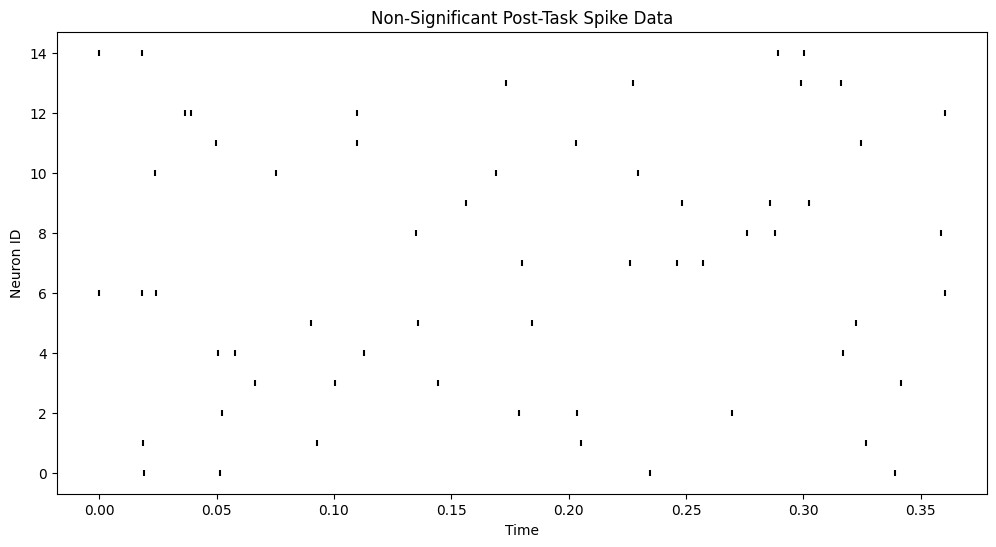

In [5]:
post_spikes_sig, post_neurons_sig, post_sig_seq_epochs = simulate_sequential_spikes(
    nneurons=N_NEURONS,
    minseqduration=MIN_SEQ_DURATION,
    maxseqduration=MAX_SEQ_DURATION,
    duration=DURATION,
    random=False,
)
post_spikes_nonsig, post_neurons_nonsig, post_nonsig_seq_epochs = (
    simulate_sequential_spikes(
        nneurons=N_NEURONS,
        minseqduration=MIN_SEQ_DURATION,
        maxseqduration=MAX_SEQ_DURATION,
        duration=DURATION,
        random=True,
    )
)

# Visualize significant post-task spike data
plt.figure(figsize=(12, 6))
plt.scatter(post_spikes_sig, post_neurons_sig, c="k", marker="|", s=18)
plt.title("Significant Post-Task Spike Data")
plt.xlabel("Time")
plt.ylabel("Neuron ID")
plt.show()

# Visualize non-significant post-task spike data
plt.figure(figsize=(12, 6))
plt.scatter(post_spikes_nonsig, post_neurons_nonsig, c="k", marker="|", s=18)
plt.title("Non-Significant Post-Task Spike Data")
plt.xlabel("Time")
plt.ylabel("Neuron ID")
plt.show()

## Section 2: Analyzing Replay with PairwiseBias

Now that we have our simulated data, let's use the PairwiseBias transformer to
analyze replay events.

In [6]:
pbias = npy.ensemble.PairwiseBias(num_shuffles=100)

# Analyze significant replay
z_score_sig, p_value_sig, cosine_val_sig = pbias.fit_transform(
    task_spikes,
    task_neurons,
    task_seq_epochs,
    post_spikes_sig,
    post_neurons_sig,
    post_sig_seq_epochs,
)

print("Significant Replay Results:")
print(f"Z-scores: {z_score_sig}")
print(f"P-values: {p_value_sig}")
print(f"Cosine values: {cosine_val_sig}")

# Analyze non-significant replay
z_score_nonsig, p_value_nonsig, cosine_val_nonsig = pbias.transform(
    post_spikes_nonsig, post_neurons_nonsig, post_nonsig_seq_epochs
)

print("\nNon-significant Replay Results:")
print(f"Z-scores: {z_score_nonsig}")
print(f"P-values: {p_value_nonsig}")
print(f"Cosine values: {cosine_val_nonsig}")

/home/cornell/Desktop/Kushaan/neuro_py/neuro_py/ensemble/replay.py:659: RuntimeWarning: Mean of empty slice


Significant Replay Results:
Z-scores: [6.01136055 5.2730831  4.95141898 5.19878733 5.22794518 5.24813793]
P-values: [0.00990099 0.00990099 0.00990099 0.00990099 0.00990099 0.00990099]
Cosine values: [0.97669051 0.98048687 0.93398034 0.97551905 0.93848145 0.93954246]

Non-significant Replay Results:
Z-scores: [-0.97897708  0.46571559  0.25575207 -1.42404218]
P-values: [0.82178218 0.31683168 0.43564356 0.92079208]
Cosine values: [-0.14344132  0.10520735  0.03944295 -0.16070039]


## Section 3: Visualizing Results

Let's create a simple visualization to compare the significant and
non-significant replay results.

Each bar represents the statistics for a single epoch of interest which may be
the occurrence of a Sharp Wave Ripple (SWR) event in the hippocampal neural
activity.

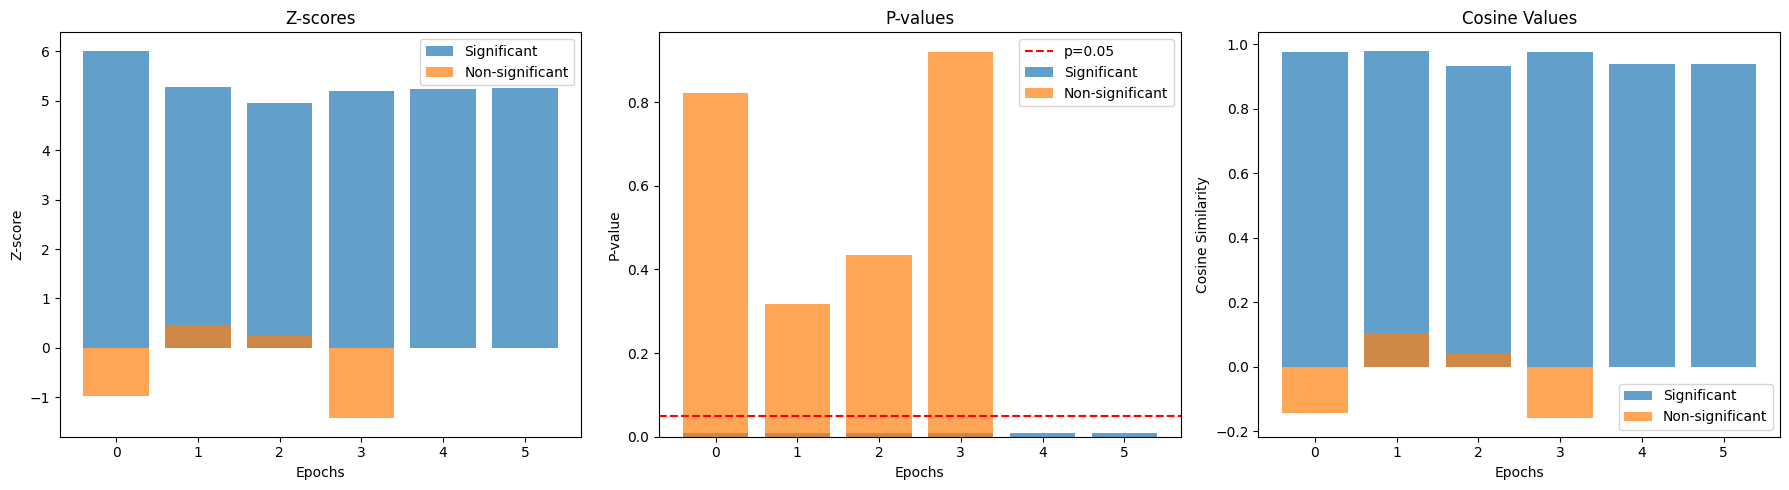

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.bar(range(len(z_score_sig)), z_score_sig, alpha=0.7, label="Significant")
ax1.bar(range(len(z_score_nonsig)), z_score_nonsig, alpha=0.7, label="Non-significant")
ax1.set_title("Z-scores")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Z-score")
ax1.legend()

ax2.bar(range(len(p_value_sig)), p_value_sig, alpha=0.7, label="Significant")
ax2.bar(range(len(p_value_nonsig)), p_value_nonsig, alpha=0.7, label="Non-significant")
ax2.set_title("P-values")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("P-value")
ax2.axhline(y=0.05, color="r", linestyle="--", label="p=0.05")
ax2.legend()

ax3.bar(range(len(cosine_val_sig)), cosine_val_sig, alpha=0.7, label="Significant")
ax3.bar(
    range(len(cosine_val_nonsig)), cosine_val_nonsig, alpha=0.7, label="Non-significant"
)
ax3.set_title("Cosine Values")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Cosine Similarity")
ax3.legend()

plt.tight_layout()
plt.show()

## Section 4: Simulation Post-Task Spike Data with both Forward and Reverse Replays

Now, let's simulate post-task spike data for both forward and reverse replay scenarios, and visualize them.

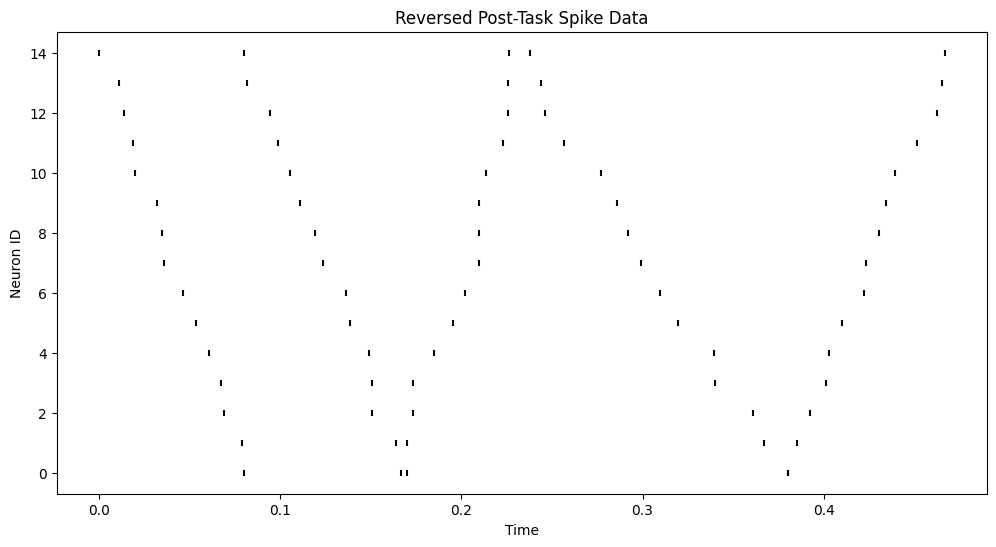

In [8]:
post_spikes_rev, post_neurons_rev, post_rev_seq_epochs = simulate_sequential_spikes(
    nneurons=N_NEURONS,
    minseqduration=MIN_SEQ_DURATION,
    maxseqduration=MAX_SEQ_DURATION,
    duration=DURATION,
    reverseseqprob=0.5,
    random=False,
)

# Visualize reversed post-task spike data
plt.figure(figsize=(12, 6))
plt.scatter(post_spikes_rev, post_neurons_rev, c="k", marker="|", s=18)
plt.title("Reversed Post-Task Spike Data")
plt.xlabel("Time")
plt.ylabel("Neuron ID")
plt.show()

Reversed Replay Results without permitting reverse sequences:
Z-scores: [-5.30841933 -5.45090389  5.03316704 -5.58233051  5.68234554]
P-values: [1.         1.         0.00990099 1.         0.00990099]
Cosine values: [-0.94051679 -0.99374011  0.98048687 -0.98048687  0.98048687]

Reversed Replay Results while permitting reverse sequences:
Z-scores: [-4.9703529  -5.2933867   5.88903521 -6.48384634  5.22551579]
P-values: [0.00990099 0.00990099 0.00990099 0.00990099 0.00990099]
Cosine values: [-0.94051679 -0.99374011  0.98048687 -0.98048687  0.98048687]


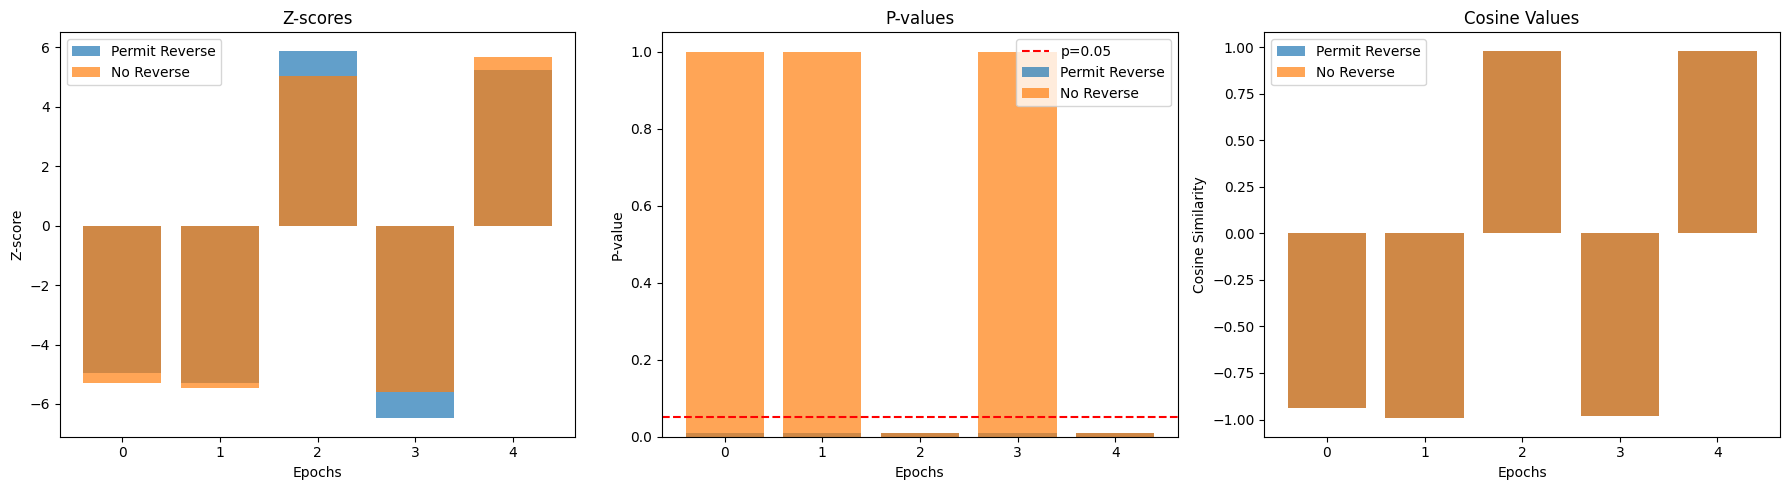

In [9]:
z_score_rev_nonsig, p_value_rev_nonsig, cosine_val_rev_nonsig = pbias.transform(
    post_spikes_rev, post_neurons_rev, post_rev_seq_epochs
)

print("Reversed Replay Results without permitting reverse sequences:")
print(f"Z-scores: {z_score_rev_nonsig}")
print(f"P-values: {p_value_rev_nonsig}")
print(f"Cosine values: {cosine_val_rev_nonsig}")

z_score_rev_sig, p_value_rev_sig, cosine_val_rev_sig = pbias.transform(
    post_spikes_rev, post_neurons_rev, post_rev_seq_epochs, allow_reverse_replay=True
)

print("\nReversed Replay Results while permitting reverse sequences:")
print(f"Z-scores: {z_score_rev_sig}")
print(f"P-values: {p_value_rev_sig}")
print(f"Cosine values: {cosine_val_rev_sig}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.bar(range(len(z_score_rev_sig)), z_score_rev_sig, alpha=0.7, label="Permit Reverse")
ax1.bar(
    range(len(z_score_rev_nonsig)), z_score_rev_nonsig, alpha=0.7, label="No Reverse"
)
ax1.set_title("Z-scores")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Z-score")
ax1.legend()

ax2.bar(range(len(p_value_rev_sig)), p_value_rev_sig, alpha=0.7, label="Permit Reverse")
ax2.bar(
    range(len(p_value_rev_nonsig)), p_value_rev_nonsig, alpha=0.7, label="No Reverse"
)
ax2.set_title("P-values")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("P-value")
ax2.axhline(y=0.05, color="r", linestyle="--", label="p=0.05")
ax2.legend()

ax3.bar(
    range(len(cosine_val_rev_sig)),
    cosine_val_rev_sig,
    alpha=0.7,
    label="Permit Reverse",
)
ax3.bar(
    range(len(cosine_val_rev_nonsig)),
    cosine_val_rev_nonsig,
    alpha=0.7,
    label="No Reverse",
)
ax3.set_title("Cosine Values")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Cosine Similarity")
ax3.legend()

plt.tight_layout()
plt.show()

In [10]:
nrn_order = np.argsort(np.nansum(pbias.task_normalized, axis=1))
sig_swr_indices = np.where(p_value_sig < 0.001)[0]


def plot_replay(n) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    start, end = post_rev_seq_epochs[n]
    start_idx = np.searchsorted(post_spikes_rev, start, side="left")
    end_idx = np.searchsorted(post_spikes_rev, end, side="right")

    filtered_spikes = post_spikes_rev[start_idx:end_idx]
    filtered_neurons = post_neurons_rev[start_idx:end_idx]

    im = ax1.imshow(pbias.task_normalized[nrn_order, :][:, nrn_order], cmap="magma")
    ax1.set_title("Template Bias Matrix")
    ax1.set_xlabel("Neuron ID (reordered by bias direction)")
    ax1.set_ylabel("Neuron ID (reordered by bias direction)")
    plt.colorbar(im, ax=ax1)

    bias = npy.ensemble.bias_matrix_fast(
        filtered_spikes,
        filtered_neurons,
        total_neurons=N_NEURONS,
        fillneutral=0.5,
    )
    bias = npy.ensemble.normalize_bias_matrix(bias)

    im = ax2.imshow(bias[nrn_order, :][:, nrn_order], cmap="magma")
    ax2.set_title("Replay Bias Matrix")
    ax2.set_xlabel("Neuron ID (reordered by bias direction)")
    ax2.set_ylabel("Neuron ID (reordered by bias direction)")
    plt.colorbar(im, ax=ax2)

    # order spikes and neuron ids by nrn_order
    argsort = np.asarray(
        sorted(
            range(len(filtered_neurons)),
            key=lambda x: nrn_order[int(filtered_neurons[x])],
        )
    )
    spike_times = filtered_spikes[argsort]
    spike_ids = filtered_neurons[argsort]
    # raster plot
    ax3.scatter(spike_times, spike_ids, c="k", marker="|", s=18)
    ax3.set_title("Replay Raster Plot")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Neuron ID (reordered by bias direction)")
    plt.tight_layout()
    plt.show()


widgets.interact(
    plot_replay,
    n=widgets.IntSlider(min=0, max=len(post_rev_seq_epochs) - 1, step=1, value=0),
);

interactive(children=(IntSlider(value=0, description='n', max=4), Output()), _dom_classes=('widget-interact',)…

## Section 5: Analyzing sequences in real data

Now that we have our simulated data, let's use the PairwiseBias transformer to
analyze replay in the SWR events.

### Section 5.1: Load the data

In [11]:
basepath = r"/run/user/1000/gvfs/smb-share:server=132.236.112.212,share=ayadata1/Data/GrosmarkAD/Achilles/Achilles_10252013"

epoch_df = npy.io.load_epoch(basepath)
# get session bounds to provide support
session_bounds = nel.EpochArray(
    [epoch_df.startTime.iloc[0], epoch_df.stopTime.iloc[-1]]
)
# compress repeated sleep sessions
epoch_df = npy.session.compress_repeated_epochs(epoch_df)
beh_epochs = nel.EpochArray(epoch_df[["startTime", "stopTime"]].values.astype(float))

st, cell_metrics = npy.io.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion="CA1"
)
spike_spindices = npy.spikes.get_spindices(st.data)

swr = npy.io.load_ripples_events(basepath, return_epoch_array=True)

theta = nel.EpochArray(npy.io.load_SleepState_states(basepath)["THETA"])

task_idx = npy.process.in_intervals(
    spike_spindices.spike_times, (beh_epochs[1] & theta).data
)

In [12]:
position_df = npy.io.load_animal_behavior(basepath)

# put position into a nelpy position array for ease of use
pos = nel.AnalogSignalArray(
    data=position_df["x"].values.T,
    timestamps=position_df.timestamps.values,
)

# get outbound and inbound epochs
(outbound_epochs, inbound_epochs) = npy.behavior.get_linear_track_lap_epochs(
    pos.abscissa_vals, pos.data[0], newLapThreshold=20
)

outbound_epochs, inbound_epochs

(<EpochArray at 0x72b5fc830640: 42 epochs> of length 17:07:964 minutes,
 <EpochArray at 0x72b5fc830b50: 43 epochs> of length 17:17:974 minutes)

In [13]:
overlap = npy.process.find_intersecting_intervals(
    swr, beh_epochs[-1], return_indices=False
)

# intervals in set 1 that completely overlap with set 2
overlap = swr.lengths == overlap

### Section 5.2: Analyzing Forward and Reverse Replays in SWR Events using PairwiseBias

In [ ]:
pbias = npy.ensemble.PairwiseBias(num_shuffles=100)

post_swrs = [
    swr[overlap][i] for i, length in enumerate(swr[overlap].lengths) if length > 0.08
]
post_swrs = nel.EpochArray(
    [ep.data for ep in post_swrs if np.sum([len(spks) > 0 for spks in st[ep].data]) > 4]
)

# Analyze significant replay
z_score_sig, p_value_sig, cosine_val_sig = pbias.fit_transform(
    spike_spindices["spike_times"].values,
    spike_spindices["spike_id"].values,
    inbound_epochs.data,
    spike_spindices["spike_times"].values,
    spike_spindices["spike_id"].values,
    post_swrs.data,
    allow_reverse_replay=False,
)

print("Significant Replay Results:")
print(f"Z-scores: {z_score_sig}")
print(f"P-values: {p_value_sig}")
print(f"Cosine values: {cosine_val_sig}")

/home/cornell/Desktop/Kushaan/neuro_py/neuro_py/ensemble/replay.py:659: RuntimeWarning: Mean of empty slice


Significant Replay Results:
Z-scores: [ 0.11456589  1.83435469 -1.58224202 ... -0.57006536 -0.16616777
 -0.82254613]
P-values: [0.46534653 0.01980198 0.95049505 ... 0.7029703  0.58415842 0.82178218]
Cosine values: [-0.00167047  0.04488326 -0.02968688 ... -0.00790766 -0.0016217
 -0.01274348]


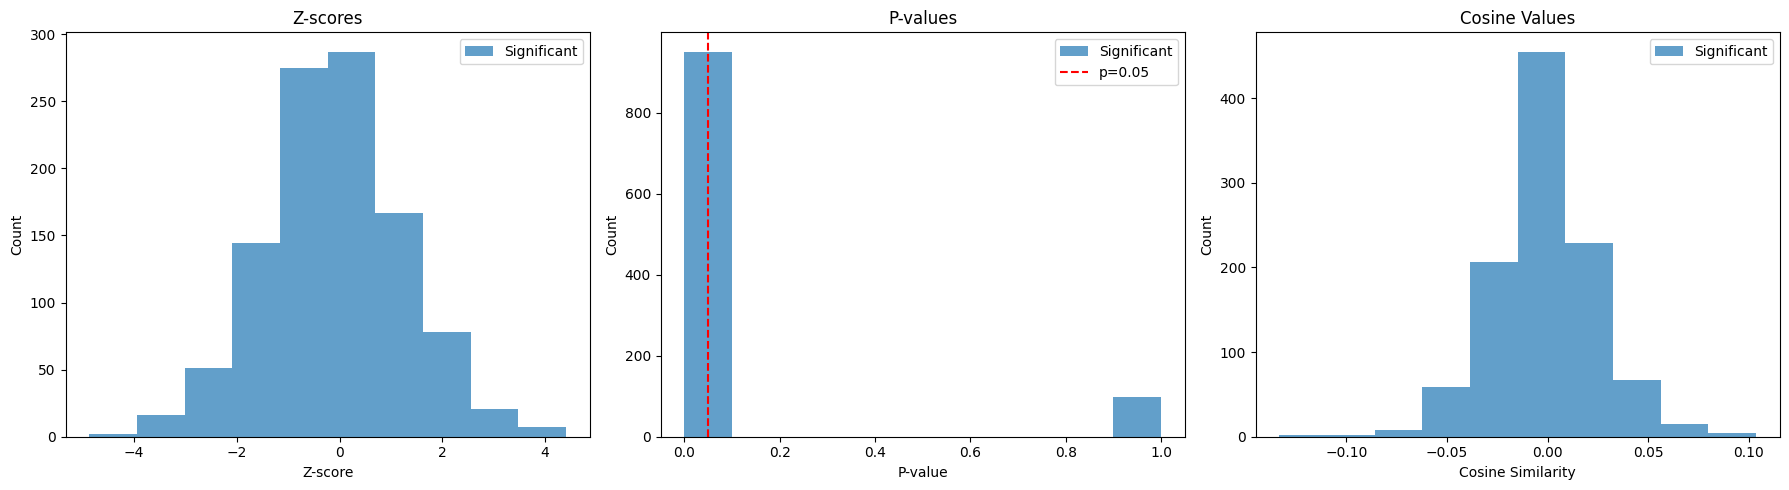

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.hist(z_score_sig, alpha=0.7, label="Significant")
# ax1.hist(z_score_nonsig, alpha=0.7, label='Non-significant')
ax1.set_title("Z-scores")
ax1.set_ylabel("Count")
ax1.set_xlabel("Z-score")
ax1.legend()

ax2.hist((p_value_sig < 0.05).astype(int), alpha=0.7, label="Significant")
# ax2.hist(p_value_nonsig, alpha=0.7, label='Non-significant')
ax2.set_title("P-values")
ax2.set_xlabel("P-value")
ax2.set_ylabel("Count")
ax2.axvline(x=0.05, color="r", linestyle="--", label="p=0.05")
ax2.legend()

ax3.hist(cosine_val_sig, alpha=0.7, label="Significant")
ax3.set_title("Cosine Values")
ax3.set_xlabel("Cosine Similarity")
ax3.set_ylabel("Count")
ax3.legend()

plt.tight_layout()
plt.show()

### Section 5.3: Forward and Reverse Replays in SWR Events using Bayesian Decoder

In [16]:
SPATIAL_BIN_SIZE = 3
BEHAVIOR_TIME_BIN_SIZE = 0.05
REPLAY_TIME_BIN_SIZE = 0.02
SPEED_THRESHOLD = 3
TUNING_CURVE_SIGMA = 1
PLACE_CELL_MIN_SPKS = 100
PLACE_CELL_MIN_RATE = 1
PLACE_CELL_PEAK_MIN_RATIO = 1.5

N_SHUFFLES = 100

In [17]:
def get_tuning_curves(
    pos, st_all, dir_epoch, speed_thres, time_binsize, s_binsize, tuning_curve_sigma
):
    spatial_maps = npy.tuning.SpatialMap(
        pos,
        st_all,
        dim=1,
        dir_epoch=dir_epoch,
        s_binsize=s_binsize,
        speed_thres=speed_thres,
        tuning_curve_sigma=tuning_curve_sigma,
        minbgrate=0.01,  # decoding does not like 0 firing rate
    )

    # restrict spike trains to those epochs during which the animal was running
    st_run = st_all[dir_epoch][spatial_maps.run_epochs]

    # bin running:
    bst_run = st_run.bin(ds=time_binsize)

    # return class 'auxiliary.TuningCurve1D'
    #   instead of class 'maps.SpatialMap' for decoding.py compatibility
    return spatial_maps.tc, st_run, bst_run, spatial_maps.run_epochs


tc, st_run, bst_run, run_epochs = get_tuning_curves(
    pos,
    st,
    inbound_epochs,
    SPEED_THRESHOLD,
    BEHAVIOR_TIME_BIN_SIZE,
    SPATIAL_BIN_SIZE,
    TUNING_CURVE_SIGMA,
)

In [18]:
def restrict_to_place_cells(
    tc,
    st_run,
    bst_run,
    st_all,
    cell_metrics,
    place_cell_min_spks,
    place_cell_min_rate,
    place_cell_peak_mean_ratio,
):
    # locate pyr cells with >= 100 spikes, peak rate >= 1 Hz, peak/mean ratio >=1.5
    peak_firing_rates = tc.max(axis=1)
    mean_firing_rates = tc.mean(axis=1)
    ratio = peak_firing_rates / mean_firing_rates

    idx = (
        (st_run.n_events >= place_cell_min_spks)
        & (tc.ratemap.max(axis=1) >= place_cell_min_rate)
        & (ratio >= place_cell_peak_mean_ratio)
    )
    unit_ids_to_keep = (np.where(idx)[0] + 1).squeeze().tolist()

    sta_placecells = st_all._unit_subset(unit_ids_to_keep)
    tc = tc._unit_subset(unit_ids_to_keep)
    total_units = sta_placecells.n_active
    bst_run = bst_run.loc[:, unit_ids_to_keep]

    # restrict cell_metrics to place cells
    cell_metrics_ = cell_metrics[idx]

    return sta_placecells, tc, bst_run, cell_metrics_, total_units


sta_placecells, tc, bst_run, cell_metrics_, total_units = restrict_to_place_cells(
    tc,
    st_run,
    bst_run,
    st,
    cell_metrics,
    PLACE_CELL_MIN_SPKS,
    PLACE_CELL_MIN_RATE,
    PLACE_CELL_PEAK_MIN_RATIO,
)

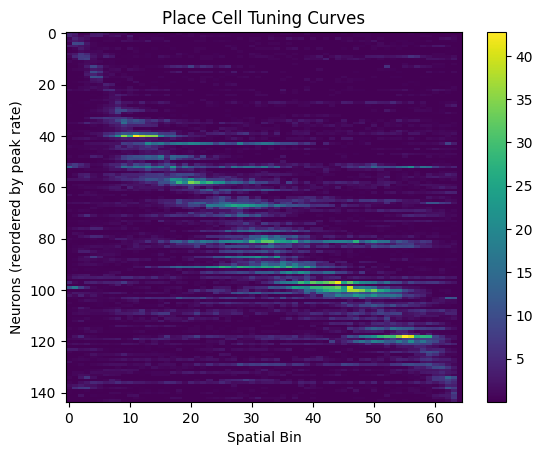

In [19]:
plt.imshow(tc.reorder_units().ratemap, aspect="auto", interpolation="none")
plt.colorbar()
plt.title("Place Cell Tuning Curves")
plt.xlabel("Spatial Bin")
plt.ylabel("Neurons (reordered by peak rate)")
plt.show()

In [20]:
def decode_and_score(bst, tc, pos):  # -> tuple[float, float] | tuple[Any, Any, Any]:
    # access decoding accuracy on behavioral time scale
    posteriors, lengths, mode_pth, mean_pth = nel.decoding.decode1D(
        bst, tc, xmin=np.nanmin(pos.data), xmax=np.nanmax(pos.data)
    )

    actual_pos = np.interp(bst.bin_centers, pos.abscissa_vals, pos.data[0])

    bad_idx = np.isnan(actual_pos) | np.isnan(mode_pth)
    actual_pos = actual_pos[~bad_idx]
    mode_pth = mode_pth[~bad_idx]
    if len(actual_pos) == 0:
        return np.nan, np.nan
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(
        actual_pos, mode_pth
    )
    median_error = np.nanmedian(np.abs(actual_pos - mode_pth))

    return mode_pth, rvalue, median_error


def pooled_incoherent_shuffle_bst(bst):
    out = copy.deepcopy(bst)
    data = out._data

    for uu in range(bst.n_units):
        segment = np.atleast_1d(np.squeeze(data[uu, :]))
        segment = np.roll(segment, np.random.randint(len(segment)))
        data[uu, :] = segment
    out._data = data
    return out


def decode_and_shuff(bst, tc, pos, n_shuffles=500):
    """ """
    pos_decoded, rvalue, median_error = decode_and_score(bst, tc, pos)

    if n_shuffles > 0:
        rvalue_time_swap = np.zeros((n_shuffles, 1))
        median_error_time_swap = np.zeros((n_shuffles, 1))

    for shflidx in range(n_shuffles):
        bst_shuff = pooled_incoherent_shuffle_bst(bst)
        _, rvalue_time_swap[shflidx], median_error_time_swap[shflidx] = (
            decode_and_score(bst_shuff, tc, pos)
        )

    return pos_decoded, rvalue, median_error, rvalue_time_swap, median_error_time_swap


bst_run_beh = sta_placecells[inbound_epochs][run_epochs].bin(ds=BEHAVIOR_TIME_BIN_SIZE)
pos_decoded, decoding_r2, median_error, decoding_r2_shuff, _ = decode_and_shuff(
    bst_run_beh, tc, pos[inbound_epochs][run_epochs], n_shuffles=N_SHUFFLES
)

In [21]:
replay_scores = []
for swr_ep in post_swrs:
    bst = sta_placecells[swr_ep].bin(ds=REPLAY_TIME_BIN_SIZE)

    slope, intercept, r2values = nel.analysis.replay.linregress_bst(bst, tc)
    replay_scores.append(r2values.item())

### Section 5.4: Comparing Replay Detection Consistency between PairwiseBias and Bayesian Decoder

In [22]:
# correlate replay scores with p-values
scipy.stats.spearmanr(
    np.abs(cosine_val_sig),  # Absolute to also consider reverse sequences
    replay_scores,
)

SignificanceResult(statistic=0.1982981181876735, pvalue=9.404532275254252e-11)

Visualize the significant replay events amongst the SWR events.

In [23]:
nrn_order = np.argsort(np.nansum(pbias.task_normalized, axis=1))
sig_swr_indices = np.where(p_value_sig < 0.05)[0]


def plot_replay(n):
    fig, axes = plt.subplots(2, 3, figsize=(11, 8))
    swrs_sig = post_swrs[sig_swr_indices]
    sig_swr_index = np.atleast_2d(swrs_sig[n].data)
    bias = npy.ensemble.bias_matrix_fast(
        spike_spindices[
            npy.process.in_intervals(spike_spindices.spike_times, sig_swr_index)
        ]["spike_times"].values,
        spike_spindices[
            npy.process.in_intervals(spike_spindices.spike_times, sig_swr_index)
        ]["spike_id"].values,
        total_neurons=st.n_units,
        fillneutral=0.5,
    )
    bias = npy.ensemble.normalize_bias_matrix(bias)
    cossim = npy.ensemble.cosine_similarity_matrices(pbias.task_normalized, bias)
    print(f"Epoch {n} Cosine Similarity: {cossim}")
    ax = axes[0, 0]
    ax.imshow(pbias.task_normalized[nrn_order, :][:, nrn_order], cmap="magma")
    ax.set_title("Template Bias Matrix")
    ax.set_xlabel("Neurons (reordered by bias direction)")
    ax.set_ylabel("Neurons (reordered by bias direction)")

    ax = axes[0, 1]
    ax.imshow(bias[nrn_order, :][:, nrn_order], cmap="magma")
    ax.set_title("Replay Bias Matrix")
    ax.set_xlabel("Neurons (reordered by bias direction)")
    ax.set_ylabel("Neurons (reordered by bias direction)")

    spike_times = spike_spindices[
        npy.process.in_intervals(spike_spindices.spike_times, sig_swr_index)
    ]["spike_times"].values
    spike_ids = spike_spindices[
        npy.process.in_intervals(spike_spindices.spike_times, sig_swr_index)
    ]["spike_id"].values
    # # order spikes and neuron ids by nrn_order
    # argsort = np.asarray(sorted(range(len(spike_ids)), key=lambda x: nrn_order[int(spike_ids[x])]))
    # spike_times = spike_times[argsort]
    # spike_ids = spike_ids[argsort]
    spike_id_ordermap = dict(zip(nrn_order, range(len(nrn_order))))
    spike_ids = np.asarray(
        [spike_id_ordermap[int(spike_id)] for spike_id in spike_ids], dtype=int
    )

    # raster plot
    ax = axes[0, 2]
    ax.scatter(spike_times, spike_ids, c="k", marker="|", s=18)
    ax.set_title("Replay Raster Plot")
    ax.set_xlabel("Time")
    ax.set_ylabel("Neurons (reordered by bias direction)")

    bst = sta_placecells[swrs_sig[n]].bin(ds=REPLAY_TIME_BIN_SIZE)

    posteriors, lengths, mode_pth, mean_pth = nel.decoding.decode1D(
        bst, tc, xmin=np.nanmin(pos.data), xmax=np.nanmax(pos.data)
    )

    spike_times = spike_spindices[
        npy.process.in_intervals(spike_spindices.spike_times, sig_swr_index)
    ]["spike_times"].values
    spike_ids = spike_spindices[
        npy.process.in_intervals(spike_spindices.spike_times, sig_swr_index)
    ]["spike_id"].values
    spike_id_ordermap = np.asarray(tc.get_peak_firing_order_ids()) - 1
    spike_id_ordermap = dict(zip(spike_id_ordermap, range(len(spike_id_ordermap))))
    # filter non-place cells
    spike_times = np.asarray(
        [ts for i, ts in enumerate(spike_times) if spike_ids[i] in spike_id_ordermap]
    )
    spike_ids = np.asarray(
        [id for id in spike_ids if id in spike_id_ordermap], dtype=int
    )
    # replace spike_ids with their peak firing order
    spike_ids = np.asarray(
        [spike_id_ordermap[int(spike_id)] for spike_id in spike_ids], dtype=int
    )

    ax = axes[1, 0]
    ax.scatter(spike_times, spike_ids, c="k", marker="|")
    ax.set_title("Replay Raster Plot")
    ax.set_xlabel("Time")
    ax.set_ylabel("Neurons (reordered by peak firing order)")

    stswr = st[swrs_sig[n]]
    stswr = stswr._unit_subset(tc.get_peak_firing_order_ids())
    stswr.reorder_units_by_ids(tc.get_peak_firing_order_ids(), inplace=True)

    ax = axes[1, 1]
    ax.plot(mode_pth, color="r", label="Mode Path")
    ax.plot(mean_pth, color="b", label="Mean Path")
    ax.set_title("Decoded Path")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.legend()

    ax = axes[1, 2]
    ax.imshow(posteriors, aspect="auto")
    ax.set_title("Posterior Probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position Bins")

    plt.tight_layout()
    plt.show()


widgets.interact(
    plot_replay,
    n=widgets.IntSlider(min=0, max=len(sig_swr_indices) - 1, step=1, value=0),
);

interactive(children=(IntSlider(value=0, description='n', max=96), Output()), _dom_classes=('widget-interact',…

## Section 6: Conclusion

In this tutorial, we've demonstrated how to use the `PairwiseBias` class to
analyze neural replay events. We simulated task and post-task spike data, and
then used the PairwiseBias object to detect significant replay events. The
results show that our method can effectively distinguish between significant and
non-significant replay, as evidenced by the Z-scores and p-values. The results
are also compared with Bayesian decoding to show the consistency of replay
detection.

Key observations:

1. The task spike data visualization shows a clear sequential pattern across
neurons.
2. The significant post-task spike data maintains a similar sequential pattern,
while the non-significant data appears more random.
3. For significant replay, we see high Z-scores and low p-values (p < 0.05).
4. For non-significant replay, we see mostly lower Z-scores and higher p-values
(p > 0.05).
5. The PairwiseBias and Bayesian decoder results show a reasonable degree of
mutual consistency in replay detection.

---